# Spotify streaming regression and predictive modeling excersize

In [4]:
#generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#import and summarize data files
# (1) Spotify Tracks Attributes and Popularity ; url = https://www.kaggle.com/datasets/melissamonfared/spotify-tracks-attributes-and-popularity
#!pip install kagglehub
import kagglehub
#path = kagglehub.dataset_download("melissamonfared/spotify-tracks-attributes-and-popularity")
#print("Path to dataset files:", path)
import os
#print(os.listdir(path))

#spotify = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/melissamonfared/spotify-tracks-attributes-and-popularity/versions/1/dataset.csv")
#path1 = kagglehub.dataset_download("mcfurland/10-m-beatport-tracks-spotify-audio-features")
#print("Path to dataset files:", path1)
#print(os.listdir(path1))

sp_track = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/sp_track.csv")
sp_release = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/sp_release.csv")
audio_features = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/audio_features.csv")
sp_artist = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/sp_artist.csv")
sp_artist_release = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/sp_artist_release.csv")
sp_artist_track = pd.read_csv("/Users/domthegreat/.cache/kagglehub/datasets/mcfurland/10-m-beatport-tracks-spotify-audio-features/versions/21/sp_artist_track.csv")

print(f"Rows in sp_track: {len(sp_track)}")
print(f"Rows in sp_release: {len(sp_release)}")
print(f"Rows in audio_features: {len(audio_features)}")
print(f"Rows in sp_artist: {len(sp_artist)}")
print(f"Rows in sp_artist_release: {len(sp_artist_release)}")
print(f"Rows in sp_artist_track: {len(sp_artist_track)}")

#unique isrcs in track table
dup_isrc_counts_audio = audio_features['isrc'].value_counts()
dup_isrc_counts_track = sp_track['isrc'].value_counts()
print(f"Rows in audio_features with a non-unique isrc: : {len(dup_isrc_counts_audio[dup_isrc_counts_audio > 1])}")
print(f"Rows in sp_track with a non-unique isrc: {len(dup_isrc_counts_track[dup_isrc_counts_track > 1])}")


Rows in sp_track: 5777707
Rows in sp_release: 713563
Rows in audio_features: 4687104
Rows in sp_artist: 676911
Rows in sp_artist_release: 3969489
Rows in sp_artist_track: 7716591
Rows in audio_features with a non-unique isrc: : 0
Rows in sp_track with a non-unique isrc: 507663


In [5]:
def uniq_list(seq):
    """Return a list of unique elements in their first-seen order."""
    return list(dict.fromkeys(seq))

In [4]:
#Understand data and relationships between tables
#Bunch of checks
#print(sp_artist_release[sp_artist_release.artist_id == '25uiPmTg16RbhZWAqwLBy5'])#.head(5))
#print(sp_release[sp_release.release_id.isin(['2LAiLAQMTiUq1wctQE9xT3','6ZqVmykZddWPV0nOqnerZY','1zHQ8gw0WRxHxkkcHk2d0d','1zHQ8gw0WRxHxkkcHk2d0d','1k3Cz2gcL0Vb9M2taYk6lw'])])
#print(sp_track[sp_track.release_id.isin(['2LAiLAQMTiUq1wctQE9xT3','6ZqVmykZddWPV0nOqnerZY','1zHQ8gw0WRxHxkkcHk2d0d','1zHQ8gw0WRxHxkkcHk2d0d','1k3Cz2gcL0Vb9M2taYk6lw'])])
#rint(sp_artist[sp_artist.artist_name.isin(['Charli XCX'])])
#print(artists_by_release.release_id.nunique())
#print(artists_by_release.info())
#print(artists_by_release.head())
#print(spotify_clean.release_id.info())
#print(spotify_clean[spotify_clean.release_id=='0000LFuOuVDo60CnTLknzP'])
#print(artists_by_release[artists_by_release.release_id=='0000LFuOuVDo60CnTLknzP'])
#print(len(artists_by_release))

print(sp_track.groupby('track_id')['release_id'].nunique().sort_values(ascending=False).max())
print(sp_track.groupby('isrc')['track_id'].nunique().sort_values(ascending=False).head())
print(sp_track.groupby('isrc')['track_title'].nunique().sort_values(ascending=False).head(5))
print(sp_artist_track.groupby('track_id')['artist_id'].nunique().sort_values(ascending=False).head())
#print(sp_track[sp_track.isrc=="ITJ870900094"])

1
isrc
DEAR41426574    58
DEKU31400043    49
DEAR41432475    47
DEKU31400024    46
DEKU31400001    46
Name: track_id, dtype: int64
isrc
ZSX000000000    13
DEEC31500021     8
GBULZ1001022     7
DEW871410048     6
ITJ870900094     6
Name: track_title, dtype: int64
track_id
1Wnd9FHTolkWKAHCYl38et    31
0uKSQmZks8hWmDyegaQK8C    28
2tQacdae7I7q2HaWceS7eH    28
1aIktFWEDvFiJQwp7YvIVJ    27
3rf1BB6E0TF0y125BTkZta    27
Name: artist_id, dtype: int64


In [6]:
#Get releases on ISRC (must first join into tracks to get release_id)
tracks = sp_track[['track_id','isrc','release_id','track_title','track_number','updated_on']]

releases = sp_release[['release_id','release_title','popularity','release_date','total_tracks','album_type','label_name','updated_on']].rename(columns={'updated_on':'updated_on_release'})

# track–release rows (many releases per isrc possible)
isrc_with_releases = tracks.merge(releases, on='release_id', how='left')

top_release_per_isrc = (
    isrc_with_releases
    .sort_values(['isrc','popularity','updated_on_release','updated_on'], ascending=[True, False, False, False])
    .drop_duplicates('isrc', keep='first')
    .loc[:, ['isrc','release_id','popularity','track_title','track_number','release_date','album_type','label_name','release_title']]
    .rename(columns={
        'popularity':'popularity_max',
        'track_title':'track_title_most_pop',
        'track_number':'track_number_most_pop',
        'release_date':'release_date_most_pop',
        'album_type':'album_type_most_pop',
        'label_name':'label_name_most_pop',
        'release_title':'release_title_most_popular'
    })
)

#print(top_release_per_isrc.head())

In [7]:
#aggregate popularity from releases
pop_stats = (
    isrc_with_releases
    .groupby('isrc', as_index=False)['popularity']
    .agg(popularity_max_calc='max', popularity_mean='mean', popularity_std='std', n_releases='count')
)
print(pop_stats.head())

           isrc  popularity_max_calc  popularity_mean  popularity_std  \
0  AAA201604180                    0              0.0             NaN   
1  AAA201604181                    0              0.0             NaN   
2  AAA201604182                    0              0.0             NaN   
3  AAA201604183                    0              0.0             NaN   
4  AAA201604184                    0              0.0             NaN   

   n_releases  
0           1  
1           1  
2           1  
3           1  
4           1  


In [8]:
#Get tracks on ISRC level
tracks_by_isrc = (
    sp_track
    .groupby('isrc', as_index=False)
    .agg(
        track_titles=('track_title', uniq_list),
        track_number_avg=('track_number','mean')
    )
)
print(tracks_by_isrc.head())

           isrc                     track_titles  track_number_avg
0  AAA201604180                        [Bruxism]               1.0
1  AAA201604181                           [Many]               2.0
2  AAA201604182                          [Onset]               3.0
3  AAA201604183  [Onset - J. G. Biberkopf Remix]               4.0
4  AAA201604184           [Onset - Imaabs Remix]               5.0


In [9]:
# Get artists by track per isrc
ta = sp_artist_track[['track_id','artist_id']].merge(
    sp_artist[['artist_id','artist_name']], on='artist_id', how='left'
).merge(
    sp_track[['track_id','isrc']], on='track_id', how='left'
)

artists_by_isrc_from_tracks = (
    ta.groupby('isrc', as_index=False)
      .agg(track_artist_ids=('artist_id', uniq_list),
           track_artist_names=('artist_name', uniq_list),
           n_track_artists=('artist_id','nunique'))
)

In [10]:
# Get artists associated with release and join back to track to get isrc context
ra = sp_artist_release[['release_id','artist_id']].merge(
    sp_artist[['artist_id','artist_name']], on='artist_id', how='left'
).merge(
    sp_track[['release_id','isrc']].drop_duplicates(), on='release_id', how='left'
)

artists_by_isrc_from_releases = (
    ra.groupby('isrc', as_index=False)
      .agg(release_artist_ids=('artist_id', uniq_list),
           release_artist_names=('artist_name', uniq_list),
           n_release_artists=('artist_id','nunique'))
)

In [11]:
# audio features are base (keeps one row per isrc)
spotify_isrcs = sp_track[['isrc']].drop_duplicates()
base = audio_features.merge(spotify_isrcs, on='isrc', how='inner', validate='one_to_one')

# sequential left-joins by isrc
spotify_clean = (base
       .merge(tracks_by_isrc, on='isrc', how='left') 
       .merge(pop_stats, on='isrc', how='left')
       .merge(top_release_per_isrc, on='isrc', how='left')
       .merge(artists_by_isrc_from_tracks, on='isrc', how='left')
       .merge(artists_by_isrc_from_releases, on='isrc', how='left')
)

# Create dummy variables separately for album type
album_type_dummies = pd.get_dummies(
    spotify_clean['album_type_most_pop'],
    prefix='album_type',
    drop_first=True,
    dtype='int64'
)

# Concatenate with original dataframe
spotify_clean = pd.concat([spotify_clean, album_type_dummies], axis=1)

print(spotify_clean.head())
print(spotify_clean.info())


           isrc  acousticness  danceability  duration_ms  energy  \
0  AD4X65752184      0.906000         0.650       296733   0.350   
1  AEA0D1991170      0.000950         0.621       191989   0.639   
2  AEA0Q2004008      0.031200         0.692       282904   0.980   
3  AEA0Q2004009      0.000558         0.516       197904   0.924   
4  AEA0Q2004010      0.009380         0.587       199471   0.910   

   instrumentalness  key  liveness  loudness  mode  ...  \
0             0.775    3    0.1140   -11.777     1  ...   
1             0.820    7    0.5060    -9.258     1  ...   
2             0.866    9    0.0969    -9.952     1  ...   
3             0.434    5    0.1530   -13.564     0  ...   
4             0.804    0    0.5630   -10.552     1  ...   

      label_name_most_pop   release_title_most_popular  \
0  Chilling Grooves Music      Organica Lounge Grooves   
1  Psychedelic Dimensions  Dimensional Journey, Vol. 2   
2                 Djjaner           Trance in My Heart   
3   

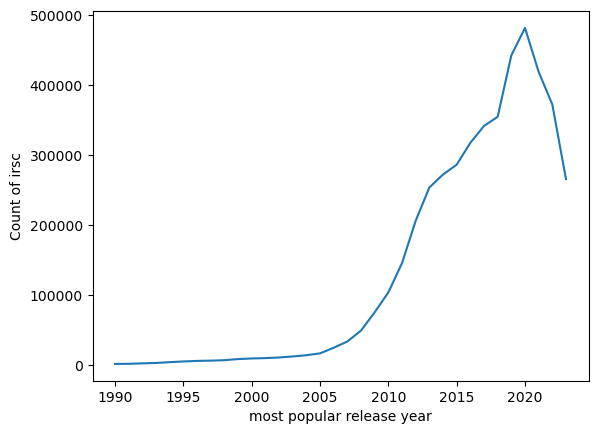

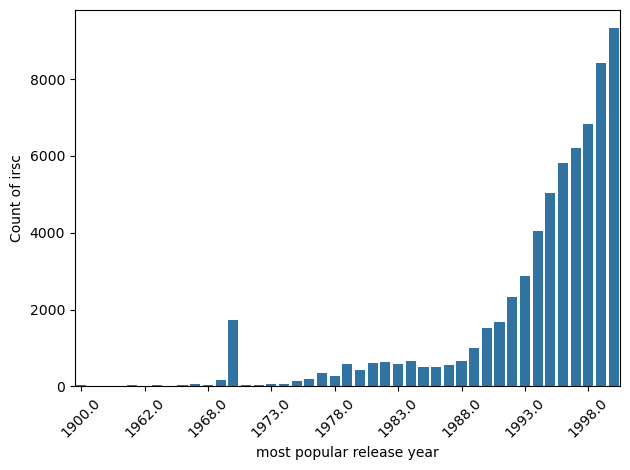

<Figure size 640x480 with 0 Axes>

In [12]:
#Number of releases by year
spotify_clean['release_year'] = pd.to_datetime(spotify_clean['release_date_most_pop'], errors='coerce').dt.year

isrc_count = spotify_clean.groupby('release_year')['isrc'].nunique().sort_index().reset_index()

sns.lineplot(data=isrc_count[isrc_count.release_year >= 1990], x='release_year', y='isrc')
plt.ylabel("Count of irsc")
plt.xlabel("most popular release year")
plt.show()
plt.clf()

sns.barplot(data=isrc_count[isrc_count.release_year <= 2000], x='release_year', y='isrc')
plt.ylabel("Count of irsc")
plt.xlabel("most popular release year")
plt.xticks(
    ticks=plt.xticks()[0][::5],rotation=45)
plt.tight_layout()
plt.show()
plt.clf()


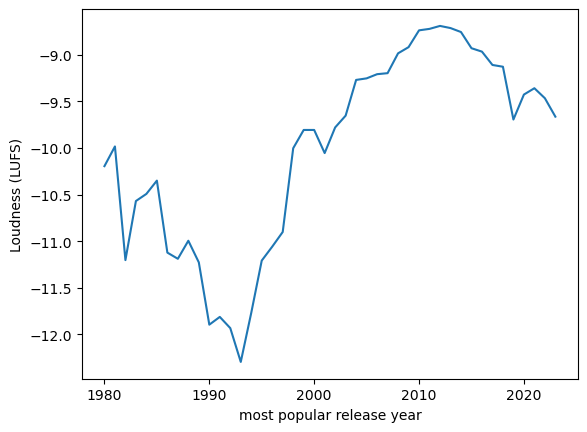

<Figure size 640x480 with 0 Axes>

In [12]:
#Loudness over time
loudness_plot = spotify_clean.groupby('release_year')['loudness'].mean().sort_index().reset_index()

sns.lineplot(data=loudness_plot[loudness_plot.release_year >= 1980], x='release_year',y='loudness')
plt.ylabel("Loudness (LUFS)")
plt.xlabel("most popular release year")
plt.show()
plt.clf()


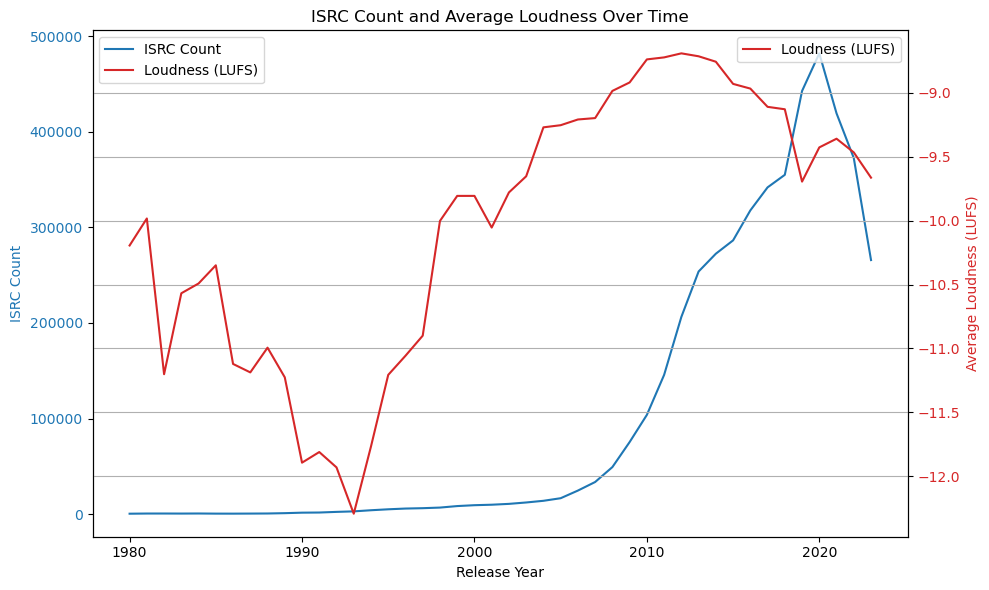

In [11]:
import matplotlib.pyplot as plt

# Group data
isrc_count = spotify_clean.groupby('release_year')['isrc'].nunique().sort_index().reset_index()
loudness_plot = spotify_clean.groupby('release_year')['loudness'].mean().sort_index().reset_index()

# Filter to reasonable years
isrc_count = isrc_count[isrc_count.release_year >= 1980]
loudness_plot = loudness_plot[loudness_plot.release_year >= 1980]

# --- Create figure and first axis ---
fig, ax1 = plt.subplots(figsize=(10,6))

# First line: ISRC count
sns.lineplot(data=isrc_count, x='release_year', y='isrc', ax=ax1, color='tab:blue', label='ISRC Count')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('ISRC Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# --- Create second axis ---
ax2 = ax1.twinx()
sns.lineplot(data=loudness_plot, x='release_year', y='loudness', ax=ax2, color='tab:red', label='Loudness (LUFS)')
ax2.set_ylabel('Average Loudness (LUFS)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('ISRC Count and Average Loudness Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/yy/_r9s4tnx76jbshqz1wbt6g1m0000gn/T/ipykernel_6997/100415722.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')


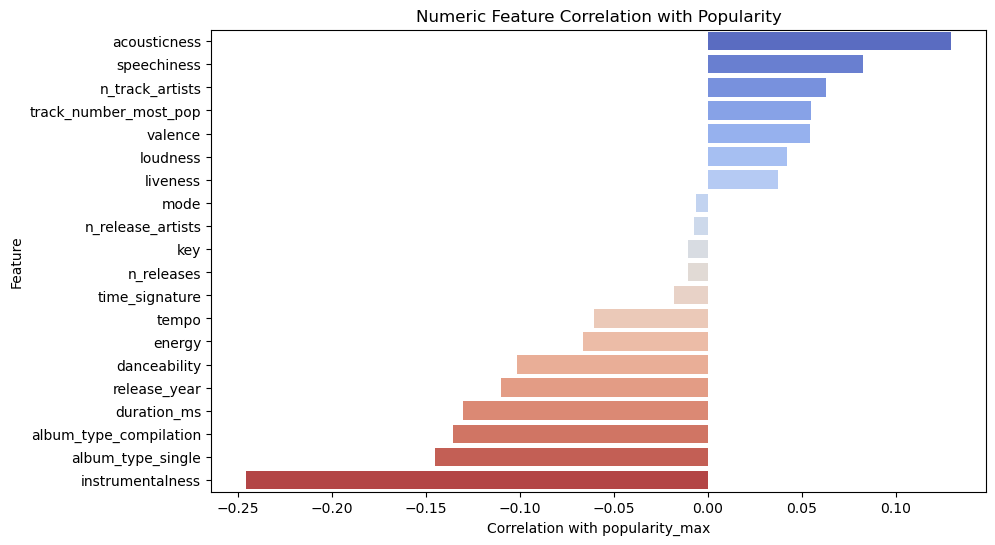

<Figure size 640x480 with 0 Axes>

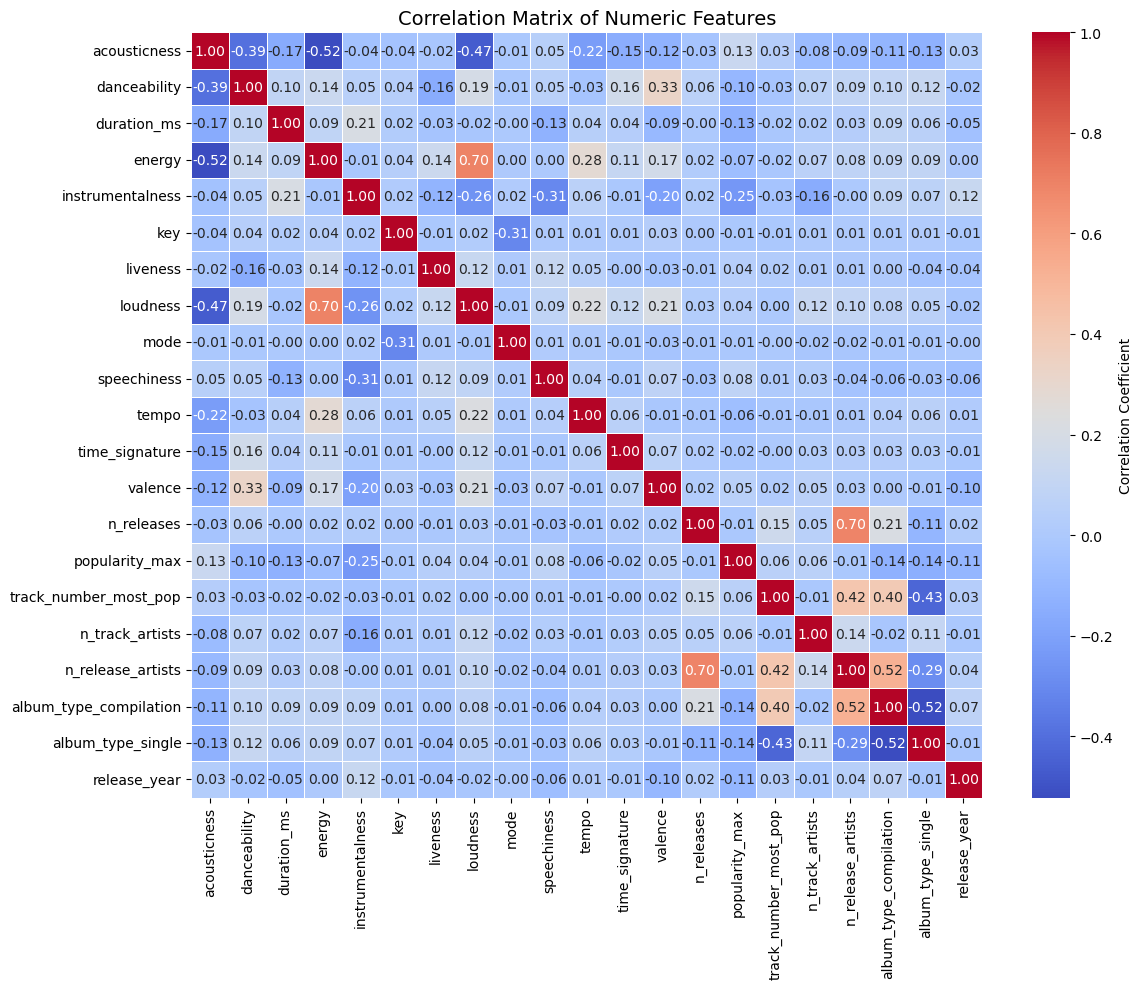

<Figure size 640x480 with 0 Axes>

In [39]:
#Explore linear relationship with popularity score
numeric_cols = spotify_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove all popularity-related fields *except* the target
for col in ['popularity_mean', 'popularity_max_calc', 'popularity_std','track_number_avg']:
    if col in numeric_cols:
        numeric_cols.remove(col)
      
# Compute correlations with popularity_max
corr = spotify_clean[numeric_cols].corr()['popularity_max'].sort_values(ascending=False)

# Drop popularity_max itself (correlation = 1)
corr = corr.drop('popularity_max', errors='ignore')

# Plot correlation with popularity
plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
plt.title('Numeric Feature Correlation with Popularity')
plt.xlabel('Correlation with popularity_max')
plt.ylabel('Feature')
plt.show()
plt.clf()

# Plot as heatmap to see matrix
# Compute full correlation matrix
corr_matrix = spotify_clean[numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,
            cmap='coolwarm', 
            annot=True,      # set to True to show correlation values
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.tight_layout()
plt.savefig("/Users/domthegreat/Desktop/my_plot1.png", dpi=300)
plt.show()
plt.clf()


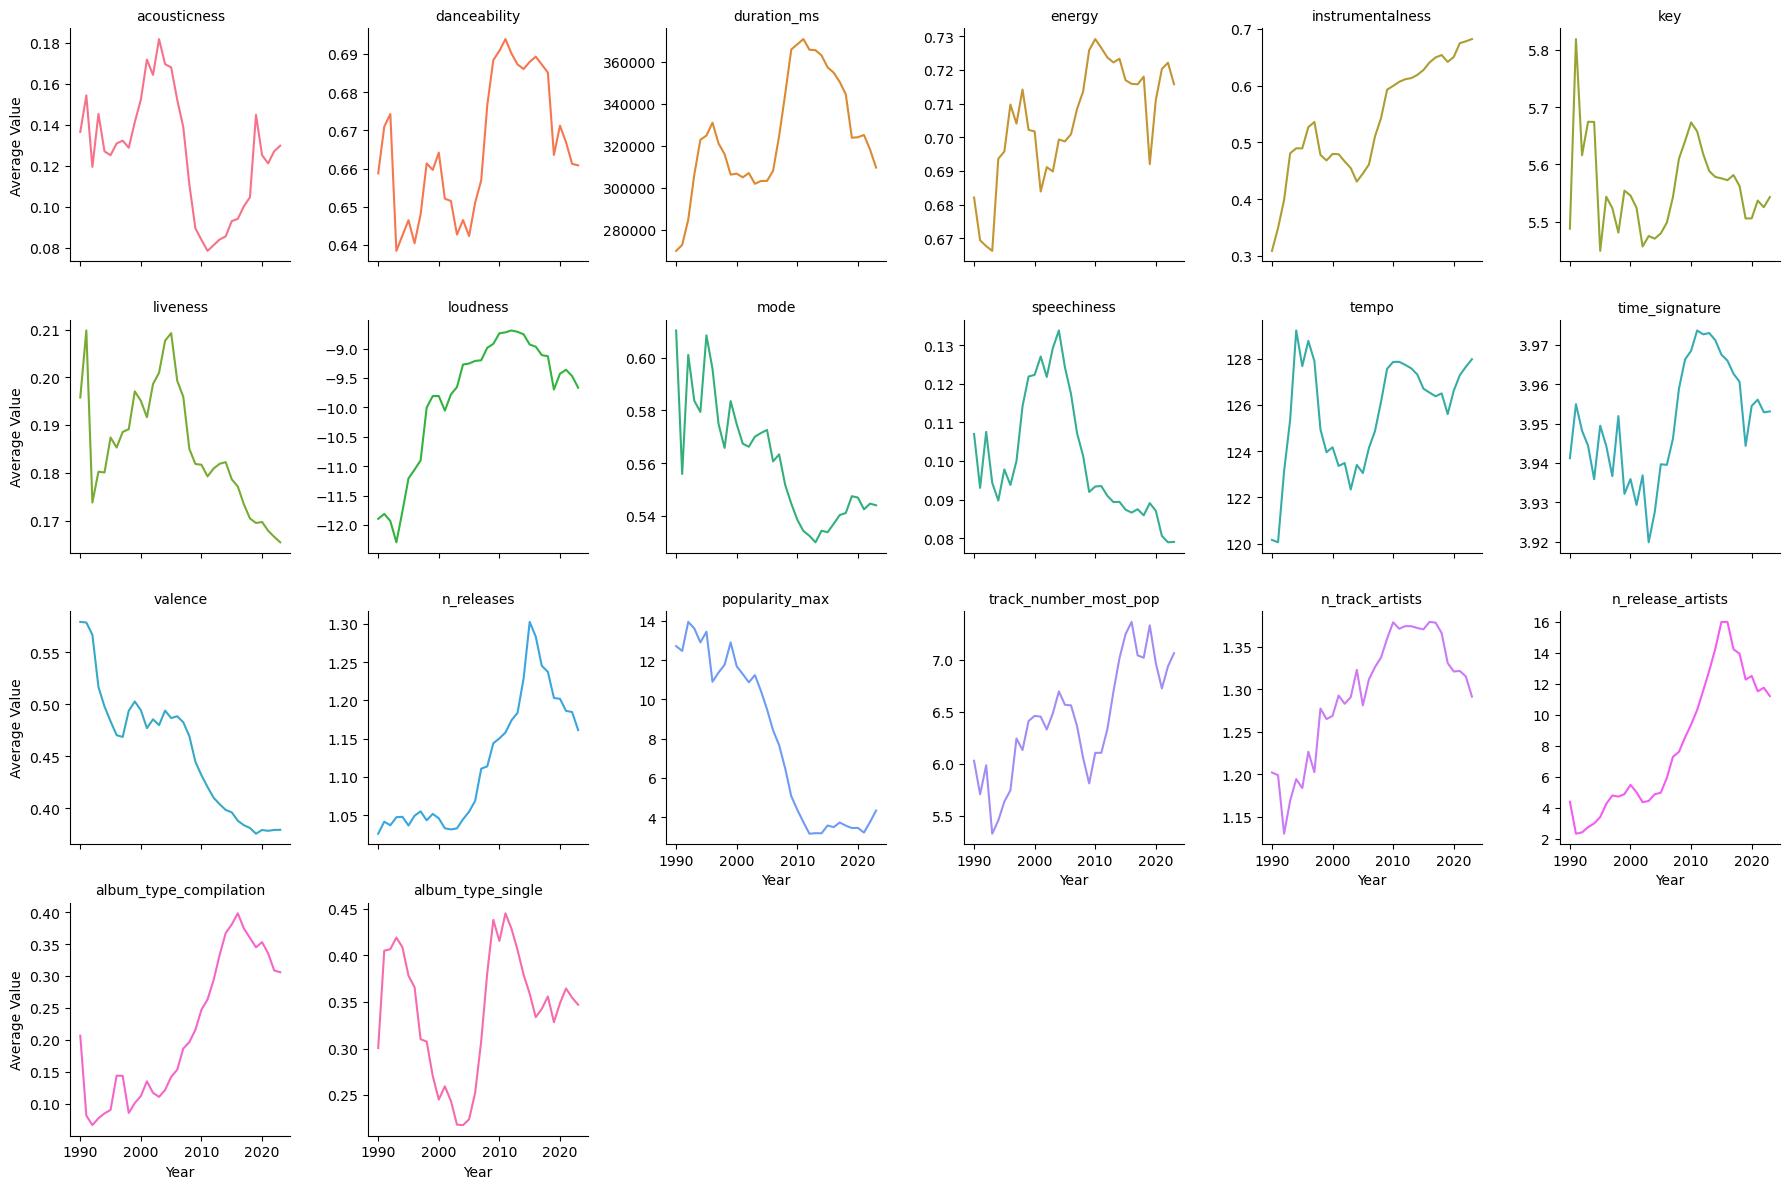

<Figure size 640x480 with 0 Axes>

In [36]:
#See how features have changed overtime
numeric_wo_year = [c for c in numeric_cols if c != 'release_year']

features = spotify_clean[numeric_wo_year + ['release_year']]

features_yearly = (
    features.groupby('release_year', as_index=False)[numeric_wo_year]
            .mean()
)

# Melt to long format for FacetGrid
features_long = pd.melt(
    features_yearly,
    id_vars=['release_year'],
    value_vars=numeric_cols,
    var_name='feature',
    value_name='mean_value'
)

grid = sns.FacetGrid(data=features_long[features_long.release_year >= 1990], col_wrap=6, col='feature', hue='feature', sharex=True, sharey=False)
grid.map_dataframe(sns.lineplot, x='release_year', y='mean_value')
grid.set_titles('{col_name}')
grid.set_axis_labels('Year', 'Average Value')
grid.figure.savefig("/Users/domthegreat/Desktop/my_plot.png", dpi=300)
plt.show()
plt.clf()

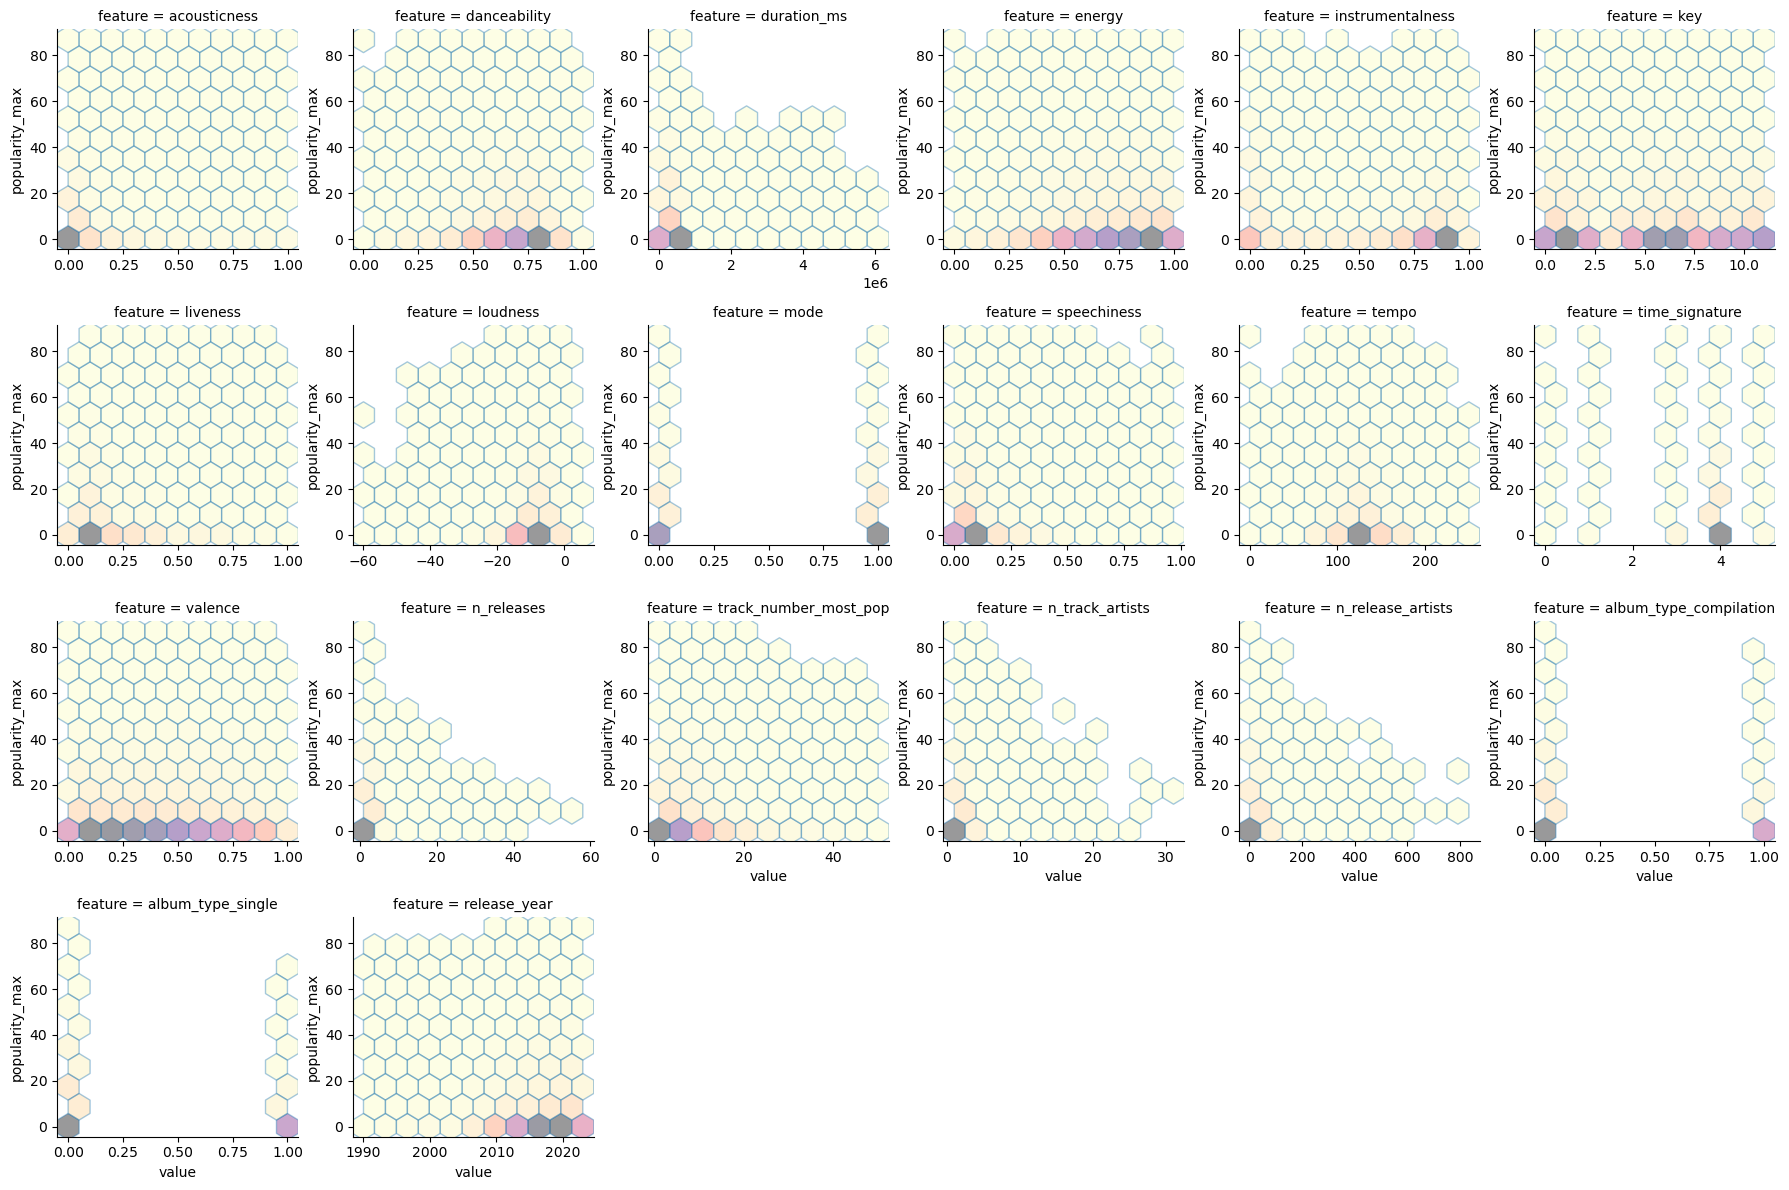

<Figure size 640x480 with 0 Axes>

In [16]:
#See more on feature to popularity relationship
#Melt numeric features and popularity into long format
features = (spotify_clean[spotify_clean.release_year >= 1990])[numeric_cols]

features_long = features.melt(
    id_vars='popularity_max',
    var_name='feature',
    value_name='value'
)

g = sns.FacetGrid(features_long, col='feature', col_wrap=6, height=3, sharex=False, sharey=False)
g.map_dataframe(plt.hexbin, 'value', 'popularity_max', gridsize=10, cmap='magma_r', alpha=0.4, mincnt=1)

for ax in g.axes.flat: ax.set_ylabel('popularity_max')

plt.show()
plt.clf()

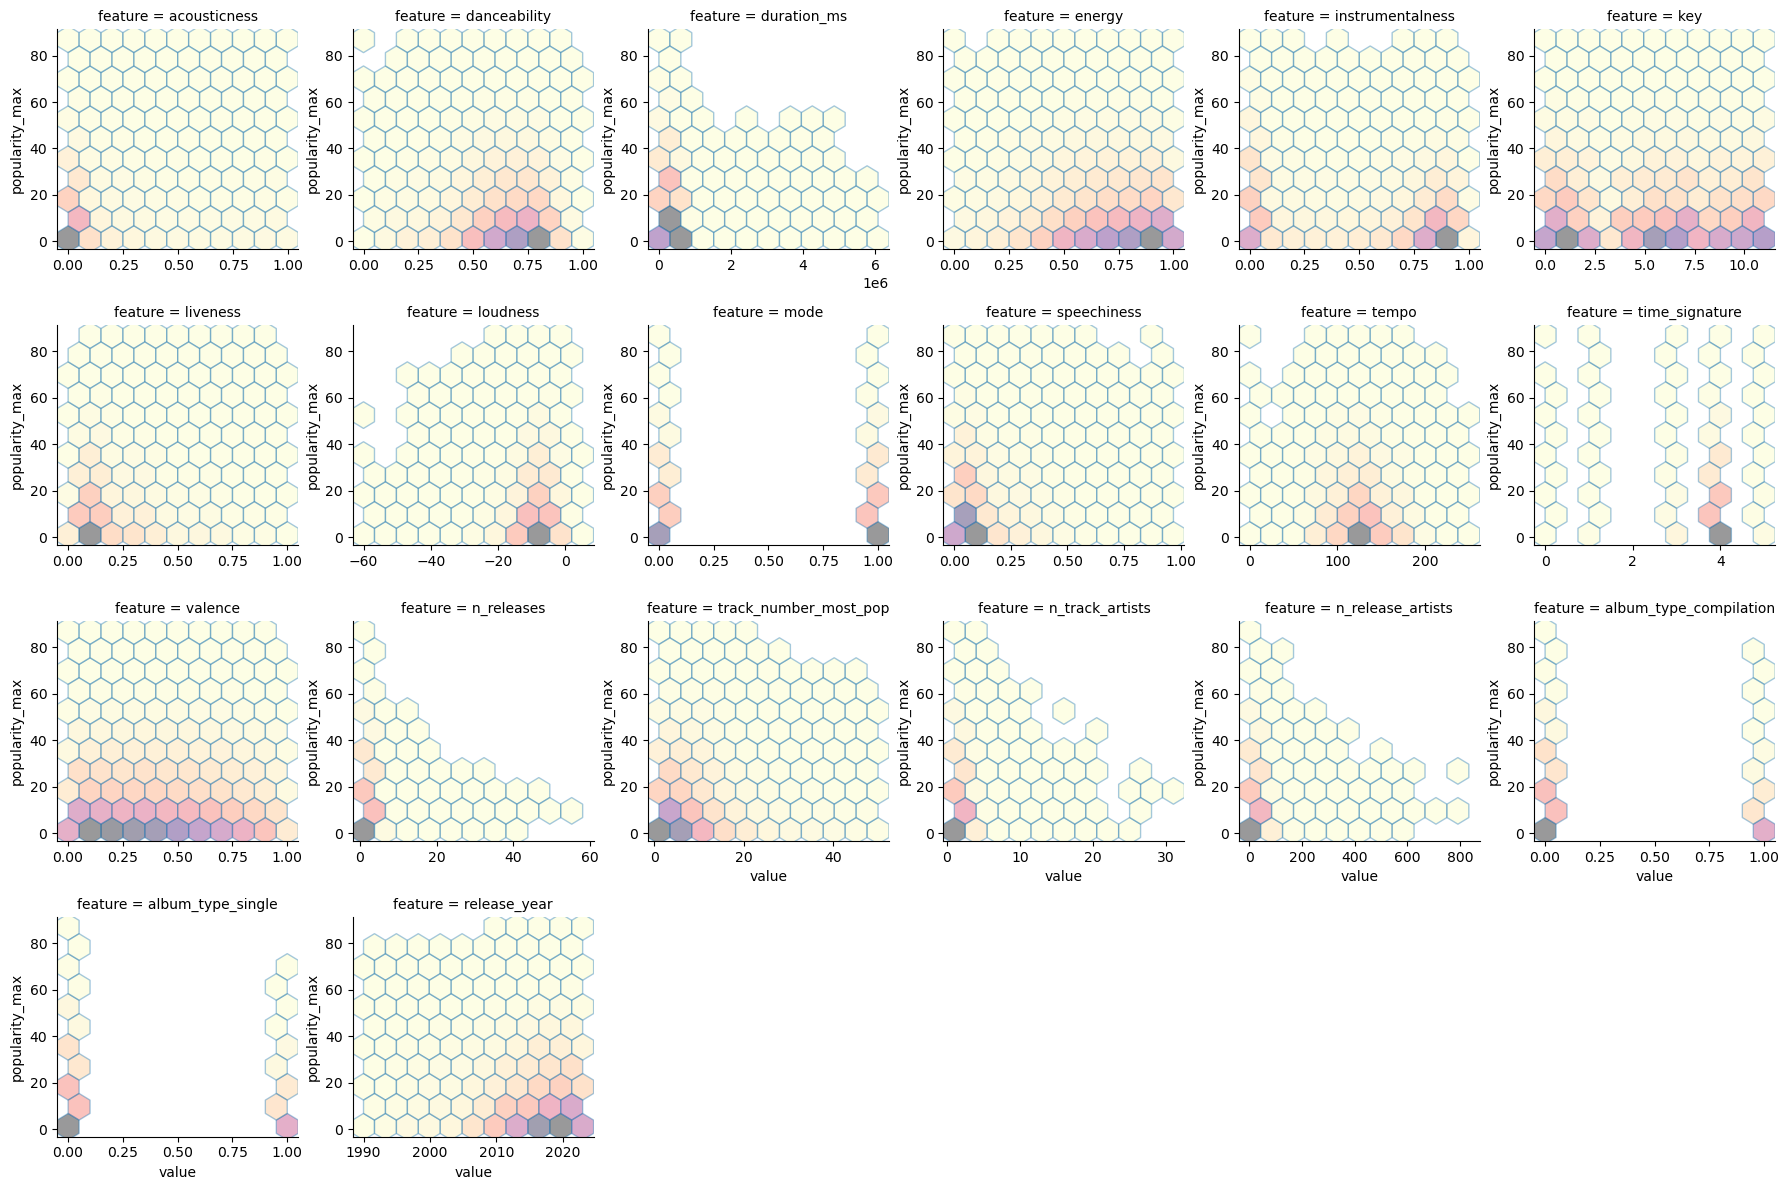

<Figure size 640x480 with 0 Axes>

In [40]:
#Same as above but filter down to popularity>0
features = (spotify_clean[(spotify_clean.release_year >= 1990) & (spotify_clean.popularity_max > 0)])[numeric_cols]

features_long = features.melt(
    id_vars='popularity_max',
    var_name='feature',
    value_name='value'
)

g = sns.FacetGrid(features_long, col='feature', col_wrap=6, height=3, sharex=False, sharey=False)
g.map_dataframe(plt.hexbin, 'value', 'popularity_max', gridsize=10, cmap='magma_r', alpha=0.4, mincnt=1)

for ax in g.axes.flat: ax.set_ylabel('popularity_max')
g.figure.savefig("/Users/domthegreat/Desktop/my_plot2.png", dpi=300)
plt.show()
plt.clf()


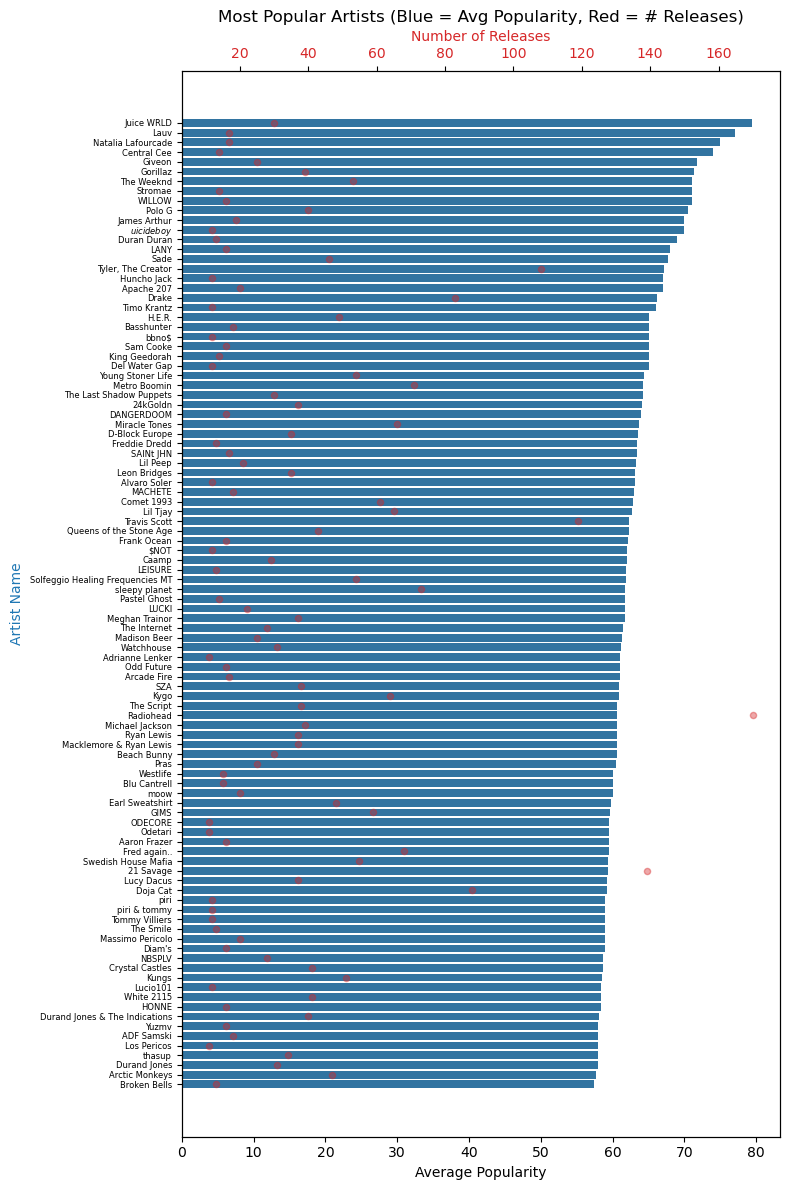

<Figure size 640x480 with 0 Axes>

In [42]:
#look at highest popularity artists
spotify_exploded = spotify_clean[spotify_clean.release_year >= 1990].explode('track_artist_names')

most_released_artists = (
    spotify_exploded
    .groupby('track_artist_names', as_index=False)['n_releases']
    .sum()
)

most_pop_artists = (
    spotify_exploded
    .groupby('track_artist_names', as_index=False)['popularity_max']
    .mean()
)

# Merge, sort by popularity, pick top 100
artist_stats = (
    most_pop_artists
    .merge(most_released_artists, on='track_artist_names')
    .sort_values('popularity_max', ascending=False)
)

#Filter to at least 10 releases
artist_stats = artist_stats[artist_stats.n_releases >= 10].head(100)

# Ensure one row per artist, no NaNs in the metric
artist_stats = artist_stats.dropna(subset=['n_releases']).copy()

# Freeze the order to exactly match the bars
order = artist_stats['track_artist_names'].tolist()

fig, ax1 = plt.subplots(figsize=(8, 12))

# Bars = average popularity (blue)
sns.barplot(
    data=artist_stats,
    x='popularity_max', y='track_artist_names',
    order=order, ax=ax1, color='tab:blue'
)
ax1.set_xlabel('Average Popularity')
ax1.set_ylabel('Artist Name', color='tab:blue')
ax1.tick_params(axis='y', labelsize=6)

# Twin x-axis for releases (red)
ax2 = ax1.twiny()

# Use scatter (or a thin bar) so you get one marker per artist without zig-zag lines
ax2.scatter(
    artist_stats['n_releases'].values,
    artist_stats['track_artist_names'].values,
    color='tab:red', s=20, alpha=0.4
)
# optional: draw short horizontal ticks instead of dots
# ax2.hlines(y=artist_stats['track_artist_names'], xmin=0,
#            xmax=artist_stats['n_releases'], colors='tab:red', linewidth=1)

ax2.set_xlabel('Number of Releases', color='tab:red')
ax2.tick_params(axis='x', labelcolor='tab:red')

plt.title('Most Popular Artists (Blue = Avg Popularity, Red = # Releases)')
plt.tight_layout()
plt.savefig("/Users/domthegreat/Desktop/my_plot3.png", dpi=300)
plt.show()
plt.clf()

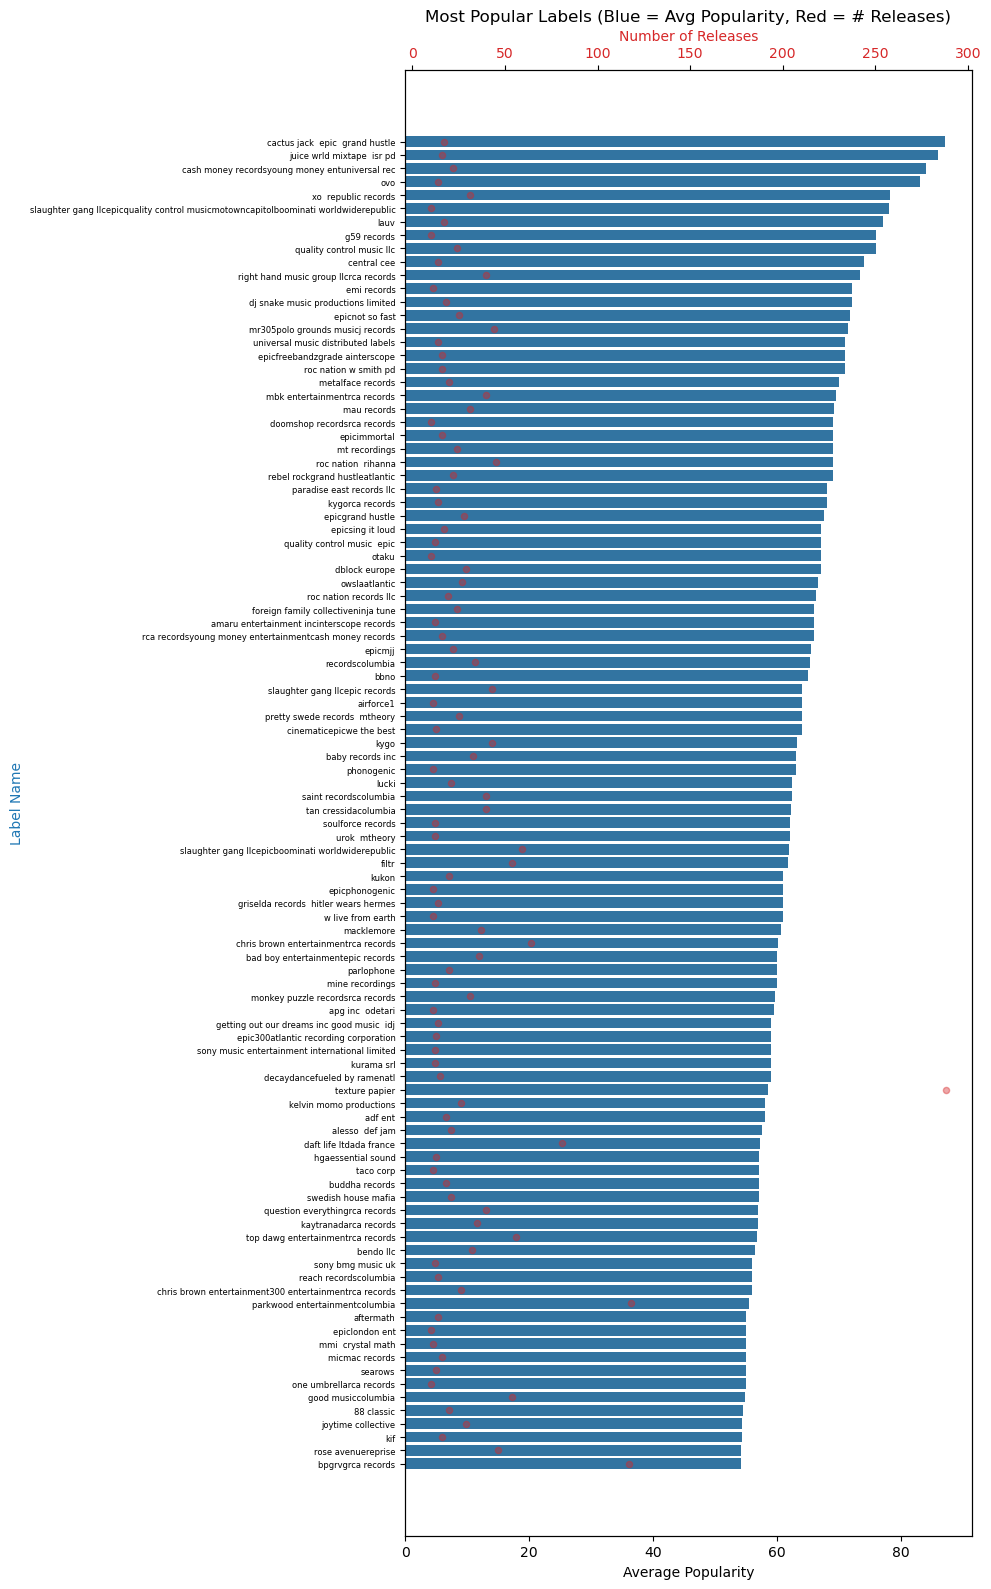

<Figure size 640x480 with 0 Axes>

In [18]:
#Label Popularity
#Clean up incidentally different label names
spotify_clean['label_name_clean'] = (
    spotify_clean['label_name_most_pop']
    .str.lower()
    .str.replace(r'[^a-z0-9 ]', '', regex=True)
    .str.strip()
)

#Filter to 1990 and beyond
spotify_clean_1990 = spotify_clean[spotify_clean.release_year >= 1990]

most_pop_labels = (
    spotify_clean_1990
    .groupby('label_name_clean', as_index=False)['popularity_max']
    .mean()
)

most_released_labels = (
    spotify_clean_1990
    .groupby('label_name_clean', as_index=False)['n_releases']
    .sum()
)

# Merge, sort by popularity
label_stats = (
    most_pop_labels
    .merge(most_released_labels, on='label_name_clean')
    .sort_values('popularity_max', ascending=False)
)

label_stats = label_stats.dropna(subset=['n_releases']).copy()

#Filter to at least 10 releases and top 100 pop
label_stats = label_stats[label_stats.n_releases >= 10].head(100)

#Normalize
# Freeze the order to exactly match the bars
order = label_stats['label_name_clean'].tolist()

fig, ax1 = plt.subplots(figsize=(10, 16))

# Bars = average popularity (blue)
sns.barplot(
    data=label_stats,
    x='popularity_max', y='label_name_clean',
    order=order, ax=ax1, color='tab:blue'
)
ax1.set_xlabel('Average Popularity')
ax1.set_ylabel('Label Name', color='tab:blue')
ax1.tick_params(axis='y', labelsize=6)

# Twin x-axis for releases (red)
ax2 = ax1.twiny()

# Use scatter (or a thin bar) so you get one marker per artist without zig-zag lines
ax2.scatter(
    label_stats['n_releases'].values,
    label_stats['label_name_clean'].values,
    color='tab:red', s=20, alpha=0.4
)
# optional: draw short horizontal ticks instead of dots
# ax2.hlines(y=artist_stats['track_artist_names'], xmin=0,
#            xmax=artist_stats['n_releases'], colors='tab:red', linewidth=1)

ax2.set_xlabel('Number of Releases', color='tab:red')
ax2.tick_params(axis='x', labelcolor='tab:red')

plt.title('Most Popular Labels (Blue = Avg Popularity, Red = # Releases)')
plt.tight_layout()
plt.show()
plt.clf()

# Let's get to the ML

In [19]:
#Predict Max Populartiy
#Make sure to:
#Model: Use RandomForestRegressor, XGBoostRegressor, or CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler 
from sklearn.decomposition import TruncatedSVD

y = spotify_clean['popularity_max']

text_features = ['track_artist_names', 'track_title_most_pop', 'label_name_clean'] #, 'release_title_most_popular']
numeric_features = [c for c in numeric_cols if c != 'popularity_max']  # just in case

X = spotify_clean[text_features + numeric_features].copy()
X[numeric_features] = X[numeric_features].astype('float32') #shave memory

# Coerce text columns to string to avoid None/list surprises
for col in text_features:
    X[col] = X[col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# treat track titles like text
title_vec = TfidfVectorizer(max_features=1000, min_df=10, dtype=np.float32, ngram_range=(1,1), sublinear_tf=True)
                                
# hash artist and label names (ID-like)
def one_token_analyzer(doc: str):
    # treat the whole string as a single token
    return [doc]

one_token = HashingVectorizer(n_features=2**15, dtype=np.float32, alternate_sign=False, analyzer=one_token_analyzer)   # identity “tokenizer”: whole string as one token
#artist_hash = HashingVectorizer(n_features=2**17, alternate_sign=False, analyzer='word', ngram_range=(1,1))
#label_hash  = HashingVectorizer(n_features=2**17, alternate_sign=False, analyzer='word', ngram_range=(1,1))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', MaxAbsScaler())           # Scale numeric variables, MaxAbsScaler to preserve RAM
        ]), numeric_features),

        ('title', title_vec, 'track_title_most_pop'),
        ('artist_name', one_token, 'track_artist_names'),
        ('label_name', one_token, 'label_name_clean'),
    ],
    remainder='drop',
    sparse_threshold=1.0
    #sparse_threshold=0.0 Only make dense for forest model
)


In [43]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687104 entries, 0 to 4687103
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_artist_names      object 
 1   track_title_most_pop    object 
 2   label_name_clean        object 
 3   acousticness            float32
 4   danceability            float32
 5   duration_ms             float32
 6   energy                  float32
 7   instrumentalness        float32
 8   key                     float32
 9   liveness                float32
 10  loudness                float32
 11  mode                    float32
 12  speechiness             float32
 13  tempo                   float32
 14  time_signature          float32
 15  valence                 float32
 16  n_releases              float32
 17  track_number_most_pop   float32
 18  n_track_artists         float32
 19  n_release_artists       float32
 20  album_type_compilation  float32
 21  album_type_single       float32

In [31]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import LinearSVR
from scipy.stats import loguniform, uniform
from joblib import Memory

memory = Memory(location="/tmp/sk_cache", verbose=0)

pop_model = Pipeline([
    ('preprocessor', preprocessor),
    #('svd', TruncatedSVD(n_components=400, random_state=42)),
    ('model', Ridge())   # placeholder, RandomizedSearchCV will swap this
], memory=memory)


param_dist = [
    # Ridge (L2)
    {
        "model": [Ridge(solver="sag", max_iter=2000, tol=1e-3)],
        "model__alpha": loguniform(1e-4, 1e1)
    },

    # LinearSVR
  #  {
   #     "model": [LinearSVR(max_iter=2000, tol=1e-3, loss="epsilon_insensitive")],
    #    "model__C": loguniform(1e-2, 1e1),       # avoid huge margins → RAM blowups
     #   "model__epsilon": uniform(0.0, 0.5),     # modest epsilon range
    #},

    # SGDRegressor
    {
       "model": [SGDRegressor(
            max_iter=2000, tol=1e-3,
            early_stopping=True, validation_fraction=0.1,
            learning_rate="optimal", average=True, random_state=42
        )],
        "model__alpha": loguniform(1e-6, 1e-3),
        "model__penalty": ["l2", "elasticnet"],
        "model__l1_ratio": uniform(0.0, 0.3)
    }
]

pop_search = RandomizedSearchCV(
    estimator=pop_model,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    n_jobs=1, #-1 will use all available
    scoring='r2',     
    random_state=42,
    error_score='raise', 
    #verbose=1
)

#Fit to sample to prevent RAM explosion
Xtr_small = X_train.sample(n=100_000, random_state=42)  # adjust to RAM
ytr_small = y_train.loc[Xtr_small.index]
pop_search.fit(Xtr_small, ytr_small)

print("Best model:", pop_search.best_estimator_["model"])
print("Best params:", pop_search.best_params_)
print("Best CV score:", pop_search.best_score_)

# Evaluate on a (smaller) test sample to keep memory stable
Xte_small = X_test.sample(n=min(100_000, len(X_test)), random_state=42)
yte_small = y_test.loc[Xte_small.index]
test_r2 = pop_search.best_estimator_.score(Xte_small, yte_small)
print("Test R^2:", test_r2)

Best model: Ridge(alpha=np.float64(8.24431219090507), max_iter=2000, solver='sag',
      tol=0.001)
Best params: {'model': Ridge(max_iter=2000, solver='sag', tol=0.001), 'model__alpha': np.float64(8.24431219090507)}
Best CV score: 0.3423980673154195
Test R^2: 0.3720579743385315


In [35]:
#Again with SVD
title_vec = TfidfVectorizer(
    max_features=5000,      # Increased to get more signal
    min_df=5,
    ngram_range=(1,2),     # Included bigrams
    sublinear_tf=True
)

one_token = HashingVectorizer(n_features=2**16, 
                              #dtype=np.float32,
                              alternate_sign=False,
                              analyzer=one_token_analyzer)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', MaxAbsScaler())           # Scale numeric variables, MaxAbsScaler to preserve RAM
        ]), numeric_features),

        ('title', title_vec, 'track_title_most_pop'),
        ('artist_name', one_token, 'track_artist_names'),
        ('label_name', one_token, 'label_name_clean'),
    ],
    remainder='drop',
    sparse_threshold=1.0
    #sparse_threshold=0.0 Only make dense for forest model
)

pop_model = Pipeline([
    ('prep', preprocessor),
    # toggle SVD on/off via param grid by swapping n_components
    ('svd', TruncatedSVD(n_components=0)),   # to be tuned
    ('model', Ridge())
], memory=memory)

param_dist = [
    # Ridge
    {
        'model': [Ridge(max_iter=5000, tol=1e-3, solver='sag')],
        'model__alpha': loguniform(1e-4, 1e2),

        # preprocessing knobs
        'prep__title__max_features': [3000, 5000, 10000],
        'prep__title__min_df': [3, 5, 10],
        'prep__title__ngram_range': [(1,1), (1,2)],
        'prep__artist_name__n_features': [2**15, 2**16, 2**17],
        'prep__label_name__n_features':  [2**15, 2**16, 2**17],
        'svd__n_components': [0, 100, 200]   # 0=off, else compress
    },
    # ElasticNet (handles correlated sparse features)
    {
        'model': [ElasticNet(max_iter=5000, tol=1e-3)],
        'model__alpha': loguniform(1e-5, 1e-1),
        'model__l1_ratio': uniform(0.05, 0.9),

        'prep__title__max_features': [3000, 5000, 10000],
        'prep__title__min_df': [3, 5, 10],
        'prep__title__ngram_range': [(1,1), (1,2)],
        'prep__artist_name__n_features': [2**15, 2**16, 2**17],
        'prep__label_name__n_features':  [2**15, 2**16, 2**17],
        'svd__n_components': [0, 100, 200]
    }
]

pop_search = RandomizedSearchCV(
    pop_model,
    param_distributions=param_dist,
    n_iter=25,        # Increased
    cv=3,
    n_jobs=1,         
    random_state=42,
    scoring='r2',
)

# Continue to downsample while tuning
Xtr_small = X_train.sample(n=150_000, random_state=42)
ytr_small = y_train.loc[Xtr_small.index]
pop_search.fit(Xtr_small, ytr_small)
#search.fit(X_train, y_train)

print("Best model:", pop_search.best_estimator_["model"])
print("Best params:", pop_search.best_params_)
print("Best CV score:", pop_search.best_score_)

Xte_small = X_test.sample(n=min(150_000, len(X_test)), random_state=42)
yte_small = y_test.loc[Xte_small.index]
test_r2 = pop_search.best_estimator_.score(Xte_small, yte_small)
print("Test R^2:", test_r2)

/Users/domthegreat/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
24 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/domthegreat/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/domthegreat/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/domthegreat/miniconda3/lib/python3.12/site-packages/skle

Best model: Ridge(alpha=np.float64(1.8537523581118498), max_iter=5000, solver='sag',
      tol=0.001)
Best params: {'model': Ridge(max_iter=5000, solver='sag', tol=0.001), 'model__alpha': np.float64(1.8537523581118498), 'prep__artist_name__n_features': 131072, 'prep__label_name__n_features': 32768, 'prep__title__max_features': 10000, 'prep__title__min_df': 3, 'prep__title__ngram_range': (1, 2), 'svd__n_components': 200}
Best CV score: 0.1665352743722387
Test R^2: 0.1695454397890026


In [37]:
#Try to understand if SVD is adding anything
from sklearn.linear_model import RidgeCV
title_vec = TfidfVectorizer(max_features=10000, #increased again
                            min_df=3,
                            ngram_range=(1,2), 
                            sublinear_tf=True)


pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('scale', MaxAbsScaler())]), numeric_features),
        ('title',  title_vec,  'track_title_most_pop'),
        ('artist', one_token, 'track_artist_names'),
        ('label',  one_token,  'label_name_clean'),
    ],
    remainder='drop',
    sparse_threshold=1.0
)

# try with and without SVD
for n_comp in [0, 100, 200]:
    steps = [('prep', pre)]
    if n_comp > 0:
        steps.append(('svd', TruncatedSVD(n_components=n_comp, random_state=42)))
    # ridge alpha sweep (logspace) — only knob
    steps.append(('model', RidgeCV(alphas=np.logspace(-4, 2, 25), cv=3)))
    pipe = Pipeline(steps)
    pipe.fit(Xtr_small, ytr_small)
    print(f"SVD comps={n_comp:>3}  CV R^2={pipe['model'].best_score_:.3f}  Test R^2={pipe.score(Xte_small, yte_small):.3f}  alpha={pipe['model'].alpha_}")

SVD comps=  0  CV R^2=0.399  Test R^2=0.441  alpha=3.1622776601683795
SVD comps=100  CV R^2=0.152  Test R^2=0.152  alpha=3.1622776601683795
SVD comps=200  CV R^2=0.166  Test R^2=0.170  alpha=3.1622776601683795


In [41]:
#SVD only adds noise. Remove SVD, stick with Ridge and calibrate text dimensions
from sklearn.model_selection import KFold

title_vec = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)

one_token = HashingVectorizer(alternate_sign=False,  analyzer=one_token_analyzer)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', MaxAbsScaler())           # Scale numeric variables, MaxAbsScaler to preserve RAM
        ]), numeric_features),

        ('title', title_vec, 'track_title_most_pop'),
        ('artist_name', one_token, 'track_artist_names'),
        ('label_name', one_token, 'label_name_clean'),
    ],
    remainder='drop',
    sparse_threshold=1.0
    #sparse_threshold=0.0 Only make dense for forest model
)

pop_model = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(max_iter=5000, solver='sparse_cg', tol=0.001))
], memory=memory)

#
param_dist = [
    # Just preprocessing 
    {
    # preprocessing knobs
        'prep__title__max_features': [5000, 10000, 15000, 20000],
        'prep__title__min_df': [3, 5, 10, 15],
        'prep__title__max_df': [0.90, 0.95, 0.98],
        'prep__title__stop_words': [None, 'english'],
        'prep__artist_name__n_features': [2**15, 2**16, 2**17],
        'prep__label_name__n_features':  [2**15, 2**16, 2**17],
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

pop_search = RandomizedSearchCV(
    pop_model,
    param_distributions=param_dist,
    n_iter=30,        
    cv=cv, # Increased
    n_jobs=1,         
    random_state=42,
    scoring='r2',
)

# Continue to downsample while tuning
Xtr_small = X_train.sample(n=150_000, random_state=42)
ytr_small = y_train.loc[Xtr_small.index]
pop_search.fit(Xtr_small, ytr_small)
#search.fit(X_train, y_train)

print("Best model:", pop_search.best_estimator_["model"])
print("Best params:", pop_search.best_params_)
print("Best CV score:", pop_search.best_score_)

Xte_small = X_test.sample(n=min(150_000, len(X_test)), random_state=42)
yte_small = y_test.loc[Xte_small.index]
test_r2 = pop_search.best_estimator_.score(Xte_small, yte_small)
print("Test R^2:", test_r2)

Best model: Ridge(max_iter=5000, solver='sparse_cg', tol=0.001)
Best params: {'prep__title__stop_words': None, 'prep__title__min_df': 5, 'prep__title__max_features': 10000, 'prep__title__max_df': 0.9, 'prep__label_name__n_features': 131072, 'prep__artist_name__n_features': 131072}
Best CV score: 0.437951968872174
Test R^2: 0.46208798793281225


In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import LinearSVR
from scipy.stats import loguniform, uniform
from joblib import Memory
from sklearn.model_selection import KFold

memory = Memory(location="/tmp/sk_cache", verbose=0)

#Lock in text features, start looking into alpha
title_vec = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, max_features=10_000, min_df=5, max_df=0.9, stop_words=None)

one_token = HashingVectorizer(alternate_sign=False,  analyzer=one_token_analyzer, n_features=2**17) #n_features is the same for artist and label

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', MaxAbsScaler())           # Scale numeric variables, MaxAbsScaler to preserve RAM
        ]), numeric_features),

        ('title', title_vec, 'track_title_most_pop'),
        ('artist_name', one_token, 'track_artist_names'),
        ('label_name', one_token, 'label_name_clean'),
    ],
    remainder='drop',
    sparse_threshold=1.0
    #sparse_threshold=0.0 Only make dense for forest model
)

pop_model = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(max_iter=5000, tol=0.001))
], memory=memory)

param_dist = [ 
    {
    # Ridge knobs
        'model__alpha': loguniform(1e-6, 1e2),
        'model__solver': ['sparse_cg','sag']
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

#One last randomized search
pop_search = RandomizedSearchCV(
    pop_model,
    param_distributions=param_dist,
    n_iter=60, #even higher than before to give the solver 'room'        
    cv=cv, 
    n_jobs=1,         
    random_state=42,
    scoring='r2',
)

# Continue to downsample while tuning
Xtr_small = X_train.sample(n=150_000, random_state=42)
ytr_small = y_train.loc[Xtr_small.index]
pop_search.fit(Xtr_small, ytr_small)
#search.fit(X_train, y_train)

print("Best model:", pop_search.best_estimator_["model"])
print("Best params:", pop_search.best_params_)
print("Best CV score:", pop_search.best_score_)

Xte_small = X_test.sample(n=min(150_000, len(X_test)), random_state=42)
yte_small = y_test.loc[Xte_small.index]
test_r2 = pop_search.best_estimator_.score(Xte_small, yte_small)
print("Test R^2:", test_r2)



Best model: Ridge(alpha=np.float64(1.5887756931672585), max_iter=5000, solver='sag',
      tol=0.001)
Best params: {'model__alpha': np.float64(1.5887756931672585), 'model__solver': 'sag'}
Best CV score: 0.44806388953618737
Test R^2: 0.47289200498288086


In [21]:
#Final alpha tuning
from sklearn.model_selection import GridSearchCV

a_star = pop_search.best_params_['model__alpha']

pop_refined = GridSearchCV(
    pop_model,
    param_grid={
        'model__solver': [pop_search.best_params_['model__solver']],   # or keep both if close
        'model__alpha': np.logspace(
            np.log10(a_star) - 1, np.log10(a_star) + 1, num=9    # a*/10 … 10*a*
        )
    },
    cv=cv,
    n_jobs=1,
    scoring='r2',
)

pop_refined.fit(Xtr_small, ytr_small)
print(pop_refined.best_params_, pop_refined.best_score_)


{'model__alpha': np.float64(1.5887756931672585), 'model__solver': 'sag'} 0.44806388953618737


In [22]:
#BEST MODEL FITTING TO FULL DATASET
best_model = pop_refined.best_estimator_
best_model.fit(X_train, y_train)  # final fit

# Evaluate on test
test_r2 = best_model.score(X_test, y_test)
print("Test R^2:", test_r2)

Test R^2: 0.6484257192813865


In [24]:
# Access trained model to better understand parameters
pipe = best_model              
prep = pipe.named_steps["prep"]
ridge = pipe.named_steps["model"]

feature_names = []

for name, trans, cols in prep.transformers_:
    if name == "remainder":
        continue

    # If this sub-transformer is a Pipeline, dig into its final step
    final_trans = trans
    if hasattr(trans, "named_steps"):
        # get the last step that actually outputs features
        final_trans = list(trans.named_steps.values())[-1]

    if name == "num":
        # numeric columns come through unchanged in count
        # ensure cols is a list
        cols_list = list(np.atleast_1d(cols))
        feature_names.extend([f"num__{c}" for c in cols_list])

    elif name == "title":
        # fitted TF-IDF vectorizer: get real feature names
        if hasattr(final_trans, "get_feature_names_out"):
            feats = final_trans.get_feature_names_out()
            feature_names.extend([f"title__{f}" for f in feats])
        else:
            raise RuntimeError("Expected TF-IDF to provide get_feature_names_out()")

    elif name in ("artist_name", "label_name"):
        # HashingVectorizer has no names; create synthetic ones
        # pull n_features from fitted transformer
        n_feat = getattr(final_trans, "n_features", None)
        if n_feat is None:
            # sklearn >=1.1 uses n_features_in_ on some objects; fall back to param
            n_feat = getattr(final_trans, "n_features_in_", None) or getattr(final_trans, "n_features", None)
        if n_feat is None:
            # last resort: use the param if available
            n_feat = getattr(final_trans, "n_features", 0)

        feature_names.extend([f"{name}__h{i}" for i in range(int(n_feat))])

    else:
        # generic fallback
        if hasattr(final_trans, "get_feature_names_out"):
            feats = final_trans.get_feature_names_out()
            feature_names.extend([f"{name}__{f}" for f in feats])
        else:
            # pass-through: one name per input column
            cols_list = list(np.atleast_1d(cols))
            feature_names.extend([f"{name}__{c}" for c in cols_list])

# Now build the coef DataFrame
coefs = ridge.coef_.ravel()
assert len(feature_names) == coefs.shape[0], f"names={len(feature_names)} vs coefs={coefs.shape[0]}"

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
print(coef_df.sort_values("abs_coef", ascending=False).head(50))

                     feature  coefficient   abs_coef
192168    label_name__h51076    69.646894  69.646894
168286    label_name__h27194    68.246616  68.246616
210211    label_name__h69119    62.809498  62.809498
171034    label_name__h29942    62.413446  62.413446
195401    label_name__h54309    62.342071  62.342071
229590    label_name__h88498    61.845006  61.845006
193449    label_name__h52357    58.520508  58.520508
210486    label_name__h69394    56.785190  56.785190
222643    label_name__h81551    56.763940  56.763940
152142    label_name__h11050    56.317470  56.317470
257070   label_name__h115978    55.316763  55.316763
267698   label_name__h126606    54.710482  54.710482
262951   label_name__h121859    54.298734  54.298734
245230   label_name__h104138    53.473513  53.473513
230082    label_name__h88990    53.279694  53.279694
258728   label_name__h117636    53.247539  53.247539
186489    label_name__h45397    52.908232  52.908232
167456    label_name__h26364    52.076870  52.

In [25]:
#Non-name features
num_only = coef_df[coef_df["feature"].str.startswith("num__")] \
           .sort_values("abs_coef", ascending=False)
print(num_only.head(30))  # top numeric coefficients

#Group Level importance
group_importance = (coef_df
    .assign(group=coef_df["feature"].str.split("__", n=1).str[0])
    .groupby("group")["abs_coef"].sum()
    .sort_values(ascending=False))
print(group_importance)

group_normed = (coef_df
    .assign(group=coef_df["feature"].str.split("__", n=1).str[0])
    .groupby("group")["abs_coef"]
    .agg(["sum", "mean", "count"])
    .assign(sum_per_feature=lambda d: d["sum"]/d["count"])
    .sort_values("sum_per_feature", ascending=False))
print(group_normed)

                        feature  coefficient   abs_coef
19            num__release_year    29.613546  29.613546
16       num__n_release_artists    22.221725  22.221725
15         num__n_track_artists    12.759857  12.759857
2              num__duration_ms   -10.587115  10.587115
7                 num__loudness     4.122085   4.122085
18       num__album_type_single    -3.259272   3.259272
17  num__album_type_compilation    -3.028314   3.028314
14   num__track_number_most_pop     1.784744   1.784744
4         num__instrumentalness    -1.108469   1.108469
0             num__acousticness     0.812732   0.812732
9              num__speechiness    -0.630061   0.630061
3                   num__energy    -0.597385   0.597385
13              num__n_releases     0.427923   0.427923
10                   num__tempo    -0.269225   0.269225
1             num__danceability    -0.245725   0.245725
11          num__time_signature     0.238993   0.238993
12                 num__valence     0.191060   0

In [26]:
#Understand regularization
print("Alpha:", ridge.alpha)
print("L2 norm of coefficients:", np.linalg.norm(ridge.coef_))

Alpha: 1.5887756931672585
L2 norm of coefficients: 1636.6389424377062


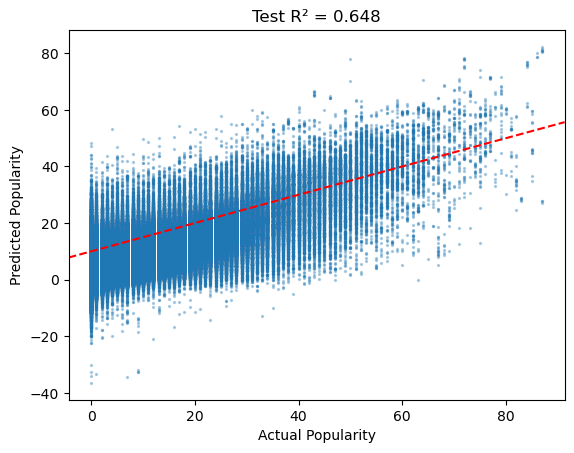

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.scatter(y_test, y_pred, s=2, alpha=0.3)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title(f"Test R² = {test_r2:.3f}")
plt.axline((0,10), slope=0.5, color='red', linestyle='--')
plt.savefig("/Users/domthegreat/Desktop/my_plot4.png", dpi=300)
plt.show()
plt.clf()

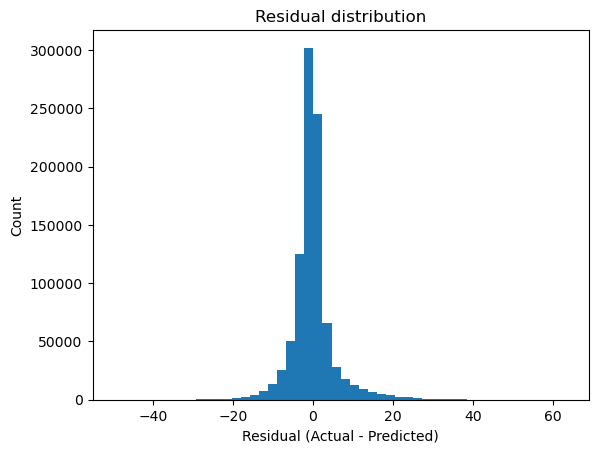

<Figure size 640x480 with 0 Axes>

In [46]:
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residual distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.savefig("/Users/domthegreat/Desktop/my_plot5.png", dpi=300)
plt.show()
plt.clf()

In [27]:
#Charli
charli = spotify_clean['track_artist_names'].apply(
    lambda artists: any('charli xcx' in a.lower() for a in artists if isinstance(a, str))
)
results = spotify_clean[charli]

#print(len(results))
#print(results.head(50))

#print(results.info())
print(results[['track_artist_names', 'track_title_most_pop','release_year','album_type_most_pop','popularity_max']].sort_values(by='release_year'))

                                        track_artist_names  \
2935931                              [Starkey, Charli XCX]   
2196733               [Starkey, Charli XCX, Darling Farah]   
2180638                              [Starkey, Charli XCX]   
2161280                     [Starkey, Charli XCX, Om Unit]   
2982253                        [Starkey, Charli XCX, Kuhn]   
1789115            [Starkey, Charli XCX, Innerpartysystem]   
2949300                              [Starkey, Charli XCX]   
2245012          [Icona Pop, Charli XCX, Sick Individuals]   
2203889             [Icona Pop, Charli XCX, Nari & Milani]   
1998994              [Icona Pop, Charli XCX, Skitzofrenix]   
1996133              [Icona Pop, Charli XCX, Style of Eye]   
4442387                           [Charli XCX, Canblaster]   
4440028                            [Charli XCX, Mike Mago]   
1922009                [Icona Pop, Charli XCX, Apocalypto]   
1871656            [Icona Pop, Charli XCX, Cobra Starship]   
3320113 

In [61]:
#
fourtet = spotify_clean['track_artist_names'].apply(
    lambda artists: any('four tet' in a.lower() for a in artists if isinstance(a, str))
)
results = spotify_clean[fourtet]

print(len(results))
#print(results.head(50))

#print(results.info())
print(results[['track_artist_names', 'track_title_most_pop','release_year','album_type_most_pop','loudness','popularity_max']].sort_values(by='release_year'))

198
                  track_artist_names  \
1156482                   [Four Tet]   
2728733                   [Four Tet]   
4063064                   [Four Tet]   
4065251                   [Four Tet]   
2616259                   [Four Tet]   
...                              ...   
2719772       [Madvillain, Four Tet]   
4137256   [Four Tet, Anthony Naples]   
4142913            [Four Tet, Happa]   
4149691         [Four Tet, Jamie xx]   
4190538  [Four Tet, Atoms For Peace]   

                                 track_title_most_pop  release_year  \
1156482                                         Field        1998.0   
2728733                                        Chiron        1999.0   
4063064                       Misnomer - Long Version        1999.0   
4065251                                         Aying        1999.0   
2616259                                    Alambradas        1999.0   
...                                               ...           ...   
2719772  Rhineston

In [28]:
#Let's make a Charli Prediction
#print(spotify_clean.info())
#print(best_model.named_steps['prep'].feature_names_in_)

charli_song = pd.DataFrame([{
    "track_artist_names": "Charli XCX",  
    "track_title_most_pop": "Sympathy is a Knife",
    "label_name_clean": "Atlantic Records",
    "acousticness": .2,
    "danceability": 0.75,
    "duration_ms": 151020,       #~2:31
    "energy": 0.85,
    "instrumentalness": 0.2,
    "key": 3.0,
    "liveness": 0.0,
    "loudness": -6.8, #Integrated LUFS reading
    "mode": 0.8,
    "speechiness": 0.55,
    "tempo": 132.0,
    "time_signature": 4,
    "valence": 0.6,
    "n_releases": 2,
    "track_number_most_pop": 3,
    "n_track_artists": 1,
    "n_release_artists": 1,
    "album_type_compilation": 0,
    "album_type_single": 0,    
    "release_year": 2024,        
}])

charli_popularity = best_model.predict(charli_song)[0]
print(f"Predicted popularity: {charli_popularity:.2f}")

Predicted popularity: 9.63


In [32]:
indie_song = pd.DataFrame([{
    "track_artist_names": "Phoebe Bridgers",  
    "track_title_most_pop": "Late Night Memory",
    "label_name_clean": "Dead Oceans",
    "acousticness": 0.85,
    "danceability": 0.45,
    "duration_ms": 245000,       # ~4:05
    "energy": 0.35,
    "instrumentalness": 0.0,
    "key": 0.0,
    "liveness": 0.15,
    "loudness": -12.0,
    "mode": 0.6,
    "speechiness": 0.05,
    "tempo": 100.0,
    "time_signature": 4,
    "valence": 0.25,
    "n_releases": 1,
    "track_number_most_pop": 1,
    "n_track_artists": 1,
    "n_release_artists": 2,
    "album_type_compilation": 0,
    "album_type_single": 0,    
    "release_year": 2024,        
}])


edm_song = pd.DataFrame([{
    "track_artist_names": "DJ Solaris",  
    "track_title_most_pop": "Neon Pulse",
    "label_name_clean": "Spinnin' Records",
    "acousticness": 0.02,
    "danceability": 0.92,
    "duration_ms": 180000,       # ~3:00
    "energy": 0.95,
    "instrumentalness": 0.5,
    "key": 7.0,
    "liveness": 0.05,
    "loudness": -5.0,
    "mode": 0.9,
    "speechiness": 0.05,
    "tempo": 138.0,
    "time_signature": 4,
    "valence": 0.8,
    "n_releases": 3,
    "track_number_most_pop": 2,
    "n_track_artists": 1,
    "n_release_artists": 1,
    "album_type_compilation": 0,
    "album_type_single": 0,    
    "release_year": 2024,        
}])

songs = pd.concat([charli_song, indie_song, edm_song], ignore_index=True)
songs["predicted_popularity"] = best_model.predict(songs)
print(songs[["track_artist_names", "track_title_most_pop", "predicted_popularity"]])

  track_artist_names track_title_most_pop  predicted_popularity
0         Charli XCX  Sympathy is a Knife              9.627953
1    Phoebe Bridgers    Late Night Memory              3.133056
2         DJ Solaris           Neon Pulse              5.374889
